In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime


pd.set_option('display.max_columns', None)
sys.path.append("../..")

from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar

## NYS Appeals

In [5]:
## External Appeal Investigation: NY, 2019-2022
# Download files locally:

# URL obtained by clicking "Export" here: https://www.dfs.ny.gov/public-appeal/search
url = "https://myportal.dfs.ny.gov/peasa-dataextract-portlet/rest/dfsservices/peasaserviceexcel"
target_filename = "nys_external_appeal_outcomes.xlsx"
download_file_from_url(url, target_filename)

Success.


In [19]:
appeal_data_path = target_filename
df = pd.read_excel(appeal_data_path)

/home/mike/venvs/investigations/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [20]:
# Clean file utils:


# Remove single 2002 record, appears accidentally included, or typo on date
df = df[df["Decision Year"] != 2002]

# Standardize agent names
df["Agent"] = df["Agent"].apply(lambda x: 'MCMC' if x == "MCMC Services, L.L.C." or x == "MCMC, LLC" else x)

In [21]:
print(f"This dataset contains a total of {len(df)} external appeals from NY.")

# Q: What is the total number of _claims_ that this corresponds to? Can corresponding total claims data be extracted from CMS PUFs?

This dataset contains a total of 24992 external appeals from NY.


#### Outcome Stats

In [36]:
def print_appeal_results(appeal_decision_counts):
    bar_names, bar_vals = list(appeal_decision_counts.index), appeal_decision_counts.values
    print(bar_names)
    print(f"{int(100* (round(bar_vals[0]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were upheld")
    print(f"{int(100* (round(bar_vals[1]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were completely overturned.")
    print(f"{int(100* (round(bar_vals[2]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were partially overturned.")
    return None

In [35]:
appeal_decision_counts = df['Appeal Decision'].value_counts()
print_appeal_results(appeal_decision_counts)

['Upheld', 'Overturned', 'Overturned in Part']
56% of all original determinations in external appeals were upheld
43% of all original determinations in external appeals were completely overturned.
2% of all original determinations in external appeals were partially overturned.


In [65]:
def get_overturn_rates_by_category(cat_col: str, by_year: bool = False) -> dict:
    decision_data = {}
    for val in df[cat_col].unique():
        decision_data[val] = {}
        rel_df = df[df[cat_col] == val]
        overturn_counts = rel_df["Appeal Decision"].value_counts()
        decision_data[val]['overall'] = {}
        overturned = overturn_counts.get("Overturned", None)
        decision_data[val]["overall"]["upheld"] = overturn_counts.get("Upheld", None)
        decision_data[val]["overall"]["completely_overturned"] = overturned
        decision_data[val]["overall"]["partially_overturned"] = overturn_counts.get("Overturned in Part", None)
        decision_data[val]["overall"]["complete_overturn_rate"] = overturned / overturn_counts.values.sum() if overturned else None

        if by_year:
            for year in rel_df["Decision Year"].unique():
                decision_data[val][year] = {}
                sub_df = rel_df[rel_df["Decision Year"] == year]
                overturn_counts = sub_df["Appeal Decision"].value_counts()
                overturned = overturn_counts.get("Overturned", None)
                decision_data[val][year]["upheld"] = overturn_counts.get("Upheld", None)
                decision_data[val][year]["completely_overturned"] = overturned
                decision_data[val][year]["partially_overturned"] = overturn_counts.get("Overturned in Part", None)
                decision_data[val][year]["complete_overturn_rate"] = overturned / overturn_counts.values.sum() if overturned else None
    return decision_data

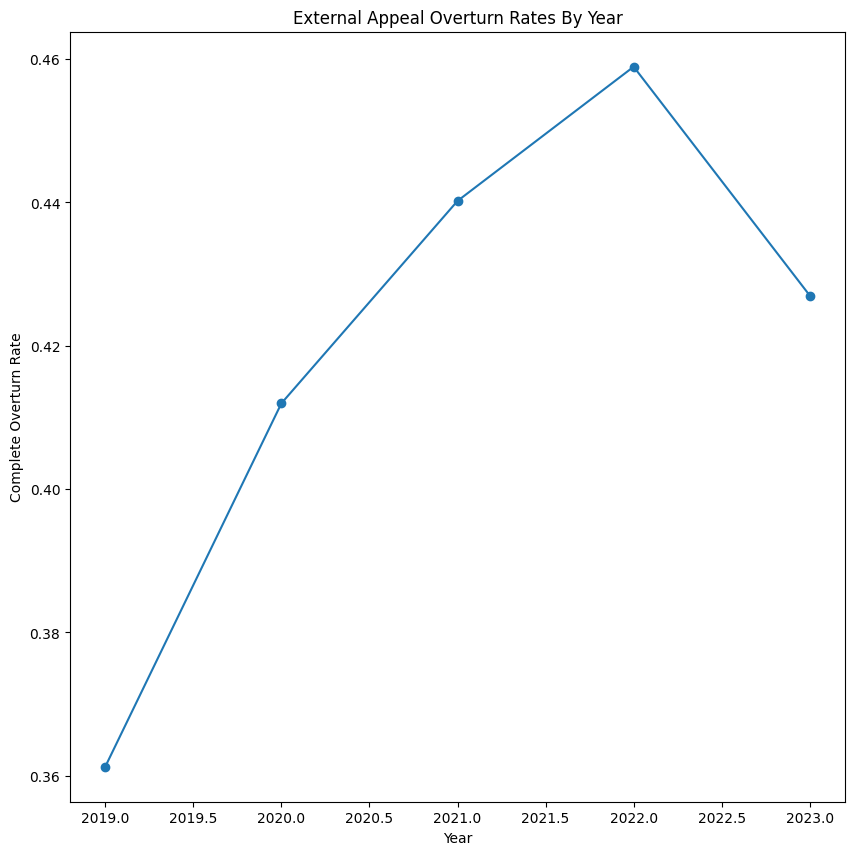

In [73]:
# Plot overall decision rates by year
overall_decision_data = get_overturn_rates_by_category("Decision Year")
fig, ax = plt.subplots(figsize=(10,10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeal Overturn Rates By Year")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if overall_decision_data.get(year, None):
        timeseries.append(overall_decision_data[year]["overall"]["complete_overturn_rate"])
    else:
        timeseries.append(None)
ax.scatter(x, timeseries)
ax.plot(x, timeseries)
plt.show()

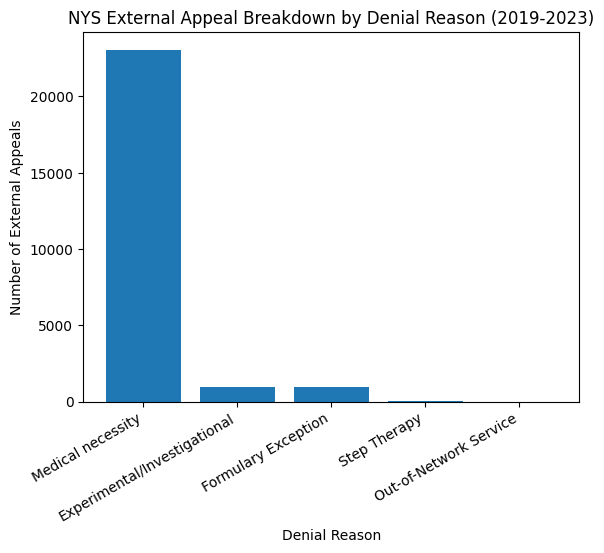

In [74]:
# Breakdown by reason
title = "NYS External Appeal Breakdown by Denial Reason (2019-2023)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Denial Reason"
denial_val_counts = df['Denial Reason'].value_counts()
bar_names, bar_vals = list(denial_val_counts.index), denial_val_counts.values
plot_bar(bar_names, bar_vals, title=title, val_axis_label=val_axis_label, cat_axis_label=cat_axis_label)

In [75]:
# Q: What are population counts here? What are initial appeal counts?
df["Health Plan"].value_counts()[:10]

Healthfirst Inc.                          4822
Fidelis Care New York                     4056
Empire Healthchoice Assurance Inc.        2551
Empire BlueCross BlueShield HealthPlus    1968
United Healthcare Plan of New York        1458
Metroplus Health Plan                     1425
Oxford                                    1196
Excellus                                   979
CVS Caremark                               779
Centers Plan for Healthy Living            635
Name: Health Plan, dtype: int64

#### Agent Breakdowns

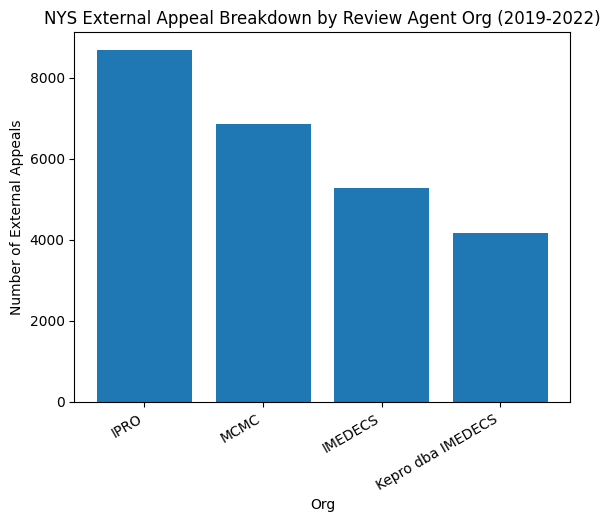

In [76]:
# Agent breakdowns
title = "NYS External Appeal Breakdown by Review Agent Org (2019-2022)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Org"
agent_val_counts = df["Agent"].value_counts()
bar_names, bar_vals = list(agent_val_counts.index), agent_val_counts.values
plot_bar(bar_names, bar_vals, title=title, val_axis_label=val_axis_label, cat_axis_label=cat_axis_label)

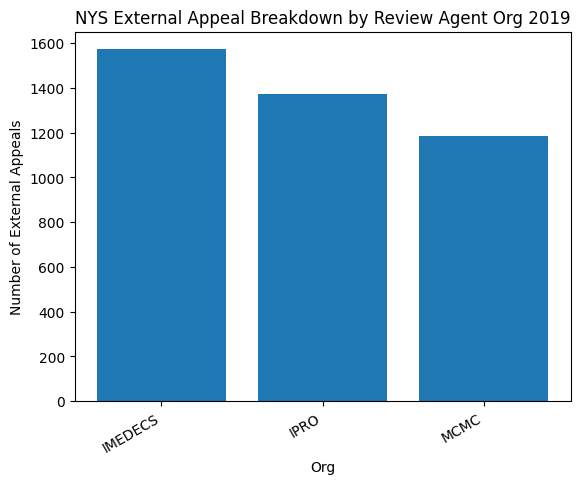

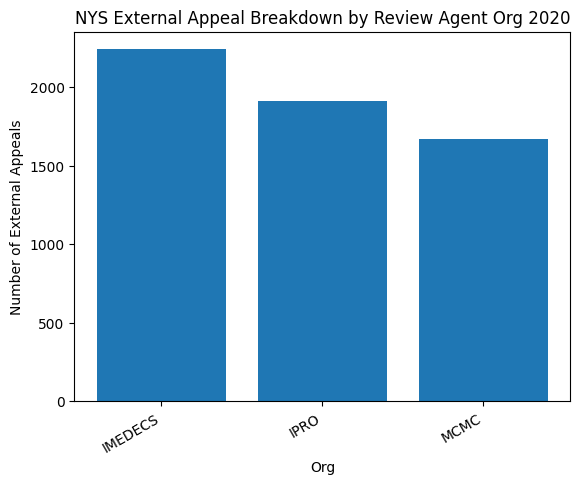

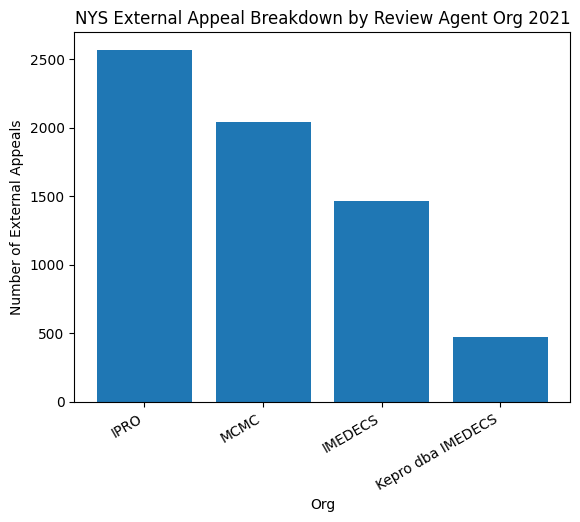

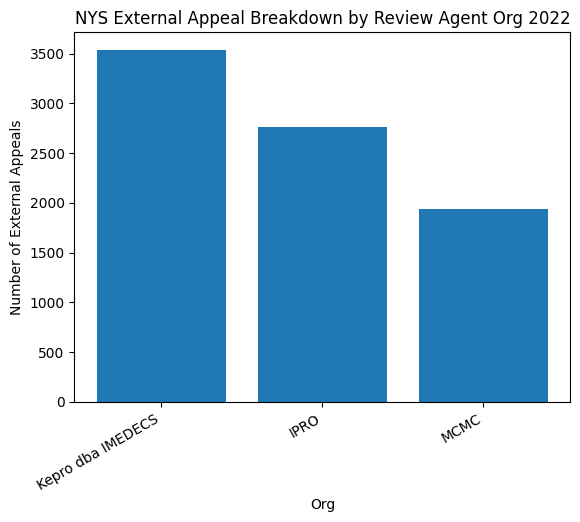

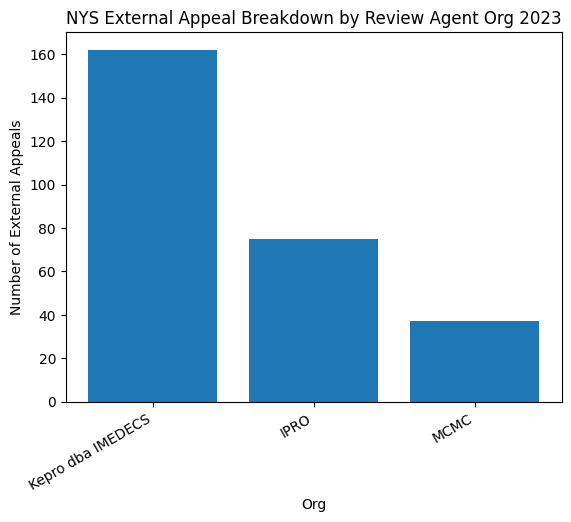

In [77]:
# Agent breakdowns by year
for year in df["Decision Year"].unique():
    rel_df = df[df["Decision Year"] == year]
    agent_val_counts = rel_df["Agent"].value_counts()
    title = f"NYS External Appeal Breakdown by Review Agent Org {year}"
    val_axis_label = "Number of External Appeals"
    cat_axis_label = "Org"
    bar_names, bar_vals = list(agent_val_counts.index), agent_val_counts.values
    plot_bar(bar_names, bar_vals, title=title, val_axis_label=val_axis_label, cat_axis_label=cat_axis_label)


In [78]:
agent_decision_data = get_overturn_rates_by_category(cat_col="Agent", by_year=True)

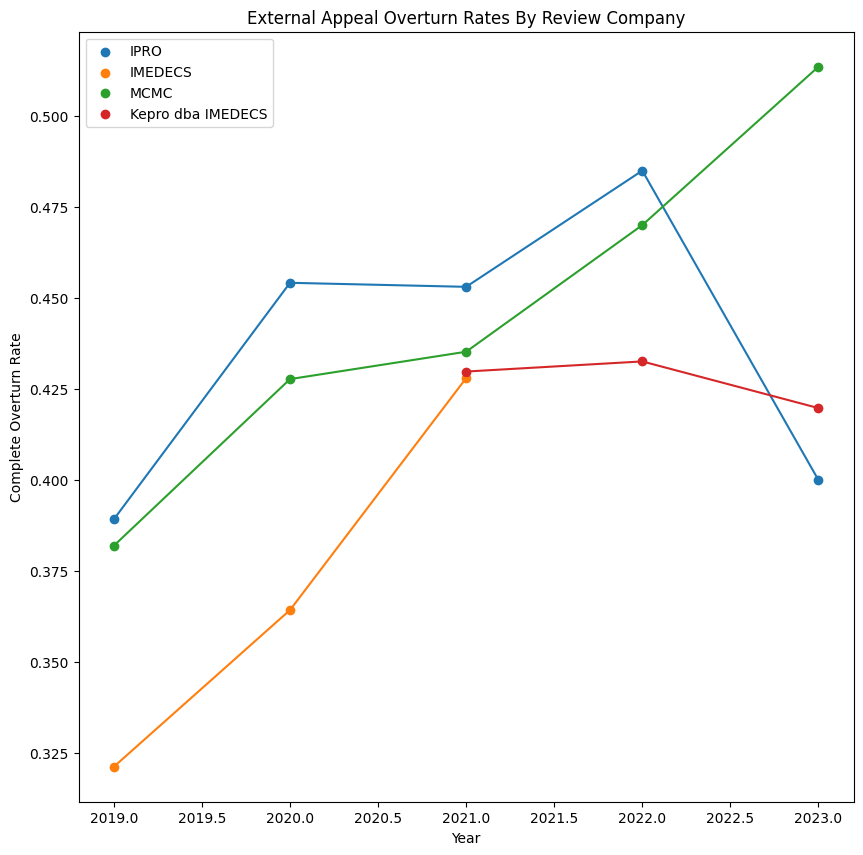

In [79]:
# Plot agent decision rates over time
fig, ax = plt.subplots(figsize=(10,10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeal Overturn Rates By Review Company")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
for agent in agent_decision_data:
    agent_timeseries = []
    for year in x:
        if agent_decision_data[agent].get(year, None):
            agent_timeseries.append(agent_decision_data[agent][year]["complete_overturn_rate"])
        else:
            agent_timeseries.append(None)
    ax.scatter(x, agent_timeseries, label=agent)
    ax.plot(x, agent_timeseries)
ax.legend()
plt.show()

# Seems overall overturn improvement is mostly due to IMEDECS -> Kepro acquisition

#### Diagnosis breakdowns

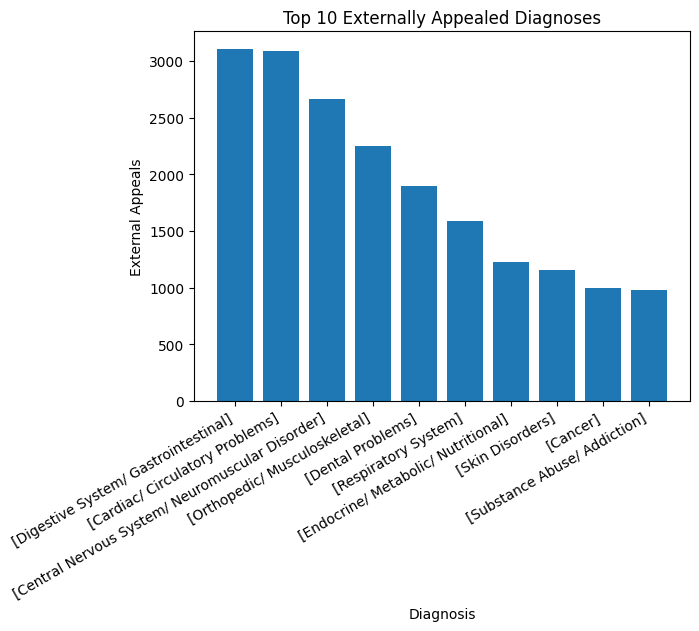

In [83]:
# Diagnosis breakdowns
n= 10
title = f"Top {n} Externally Appealed Diagnoses"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = df["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = list(diagnosis_val_counts.index), diagnosis_val_counts.values
plot_bar(bar_names, bar_vals, title=title, val_axis_label=val_axis_label, cat_axis_label=cat_axis_label)

In [81]:
diagnosis_decision_data = get_overturn_rates_by_category(cat_col="Diagnosis", by_year=True)

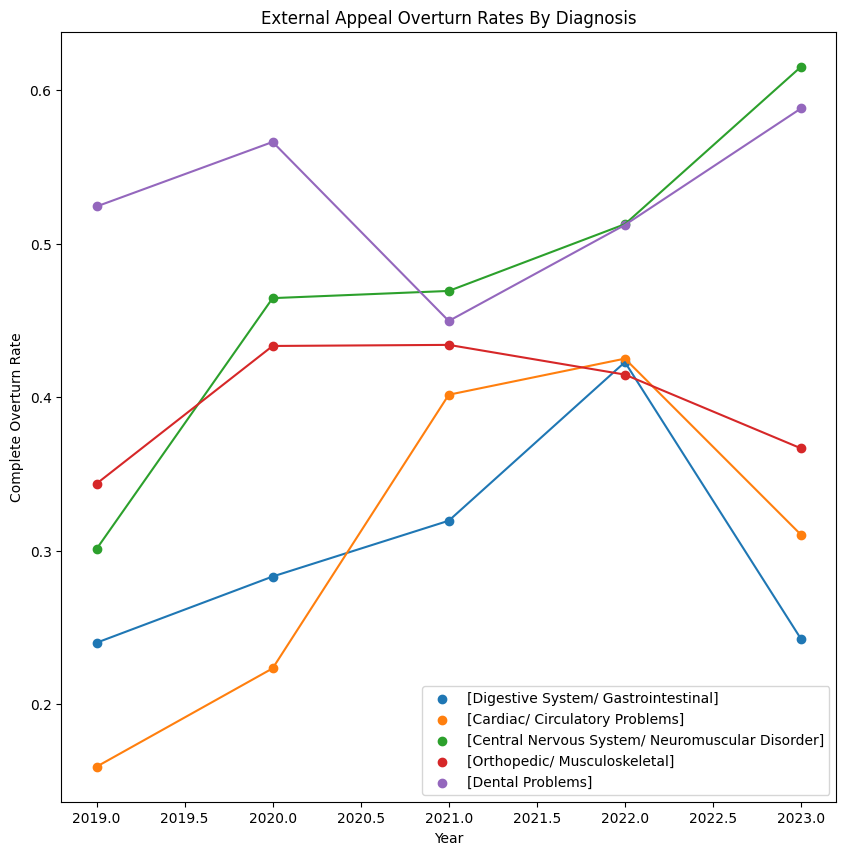

In [91]:
# Plot diagnosis decision rates over time
fig, ax = plt.subplots(figsize=(10,10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeal Overturn Rates By Diagnosis")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
for diagnosis in diagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(diagnosis_decision_data[diagnosis][year]["complete_overturn_rate"])
        else:
            timeseries.append(None)
    ax.scatter(x, timeseries, label=diagnosis)
    ax.plot(x, timeseries)
ax.legend()
plt.show()

#### Breakdown by Age

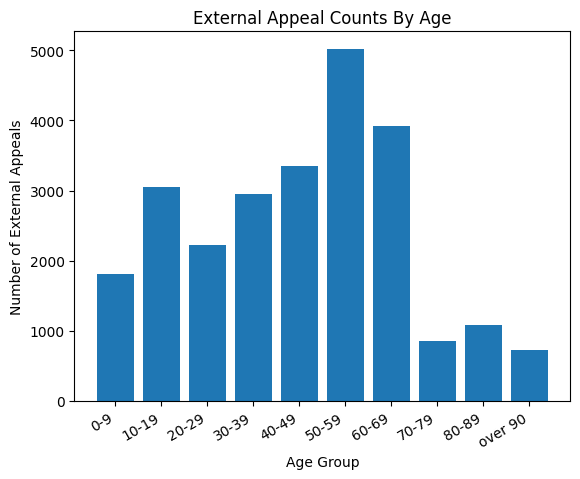

In [92]:
appeals_by_age = df["Age Range"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
sort_order = np.argsort(bar_names)
bar_names = [bar_names[x] for x in sort_order]
bar_vals = [bar_vals[x] for x in sort_order]
title = "External Appeal Counts By Age"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Age Group"
plot_bar(bar_names, bar_vals, title=title, val_axis_label=val_axis_label, cat_axis_label=cat_axis_label)
# May or may not coincide with claims counts by age? Looks not skewed enough toward elderly for that to be true

In [95]:
# Success rate by age
age_decision_data = get_overturn_rates_by_category(cat_col="Age Range", by_year=True)

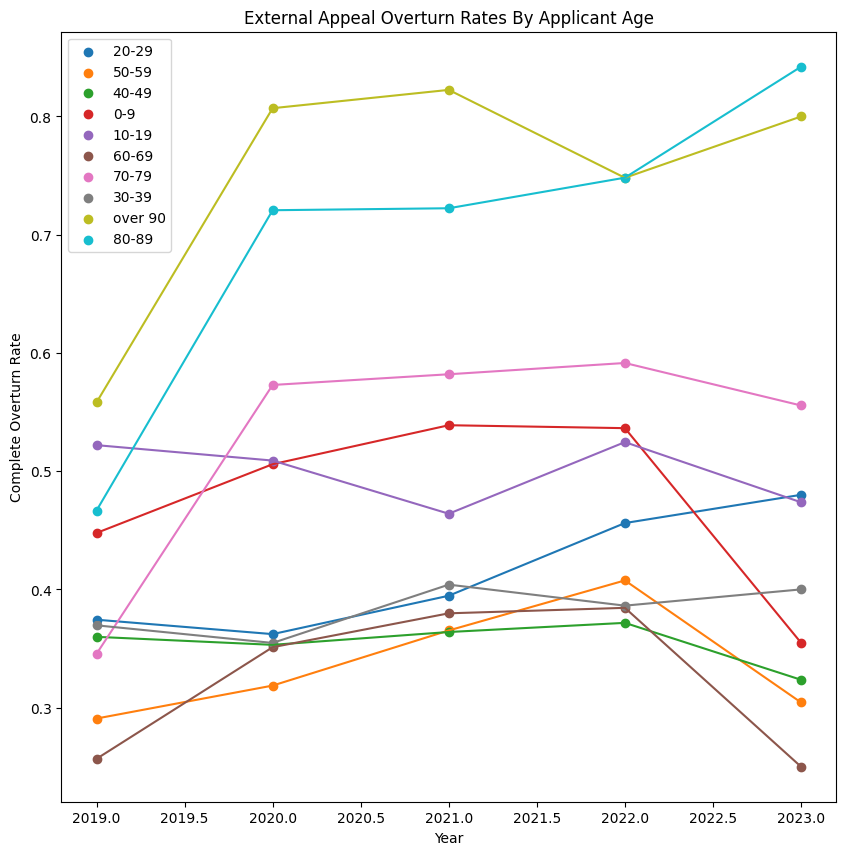

In [99]:
# Plot agent decision rates over time
fig, ax = plt.subplots(figsize=(10,10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeal Overturn Rates By Applicant Age")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
for age in age_decision_data:
    age_timeseries = []
    for year in x:
        if age_decision_data[age].get(year, None):
            age_timeseries.append(age_decision_data[age][year]["complete_overturn_rate"])
        else:
            age_timeseries.append(None)
    ax.scatter(x, age_timeseries, label=age)
    ax.plot(x, age_timeseries)
ax.legend()
plt.show()


#### Breakdown By Gender

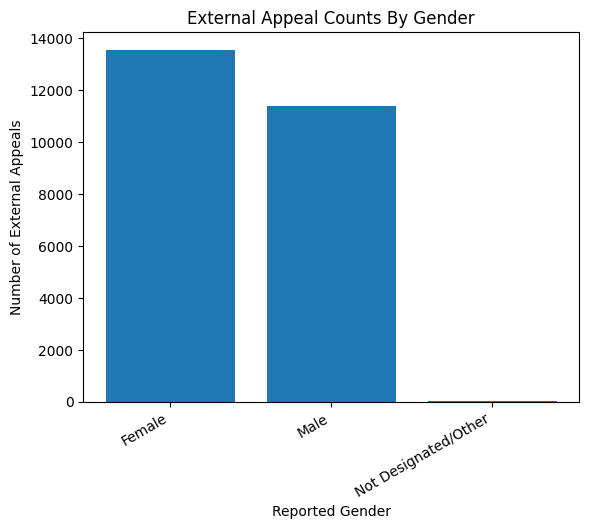

In [97]:
appeals_by_age = df["Gender"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
title = "External Appeal Counts By Gender"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Reported Gender"
plot_bar(bar_names, bar_vals, title=title, val_axis_label=val_axis_label, cat_axis_label=cat_axis_label)

In [98]:
# Success rate by gender
gender_decision_data = get_overturn_rates_by_category(cat_col="Gender", by_year=True)

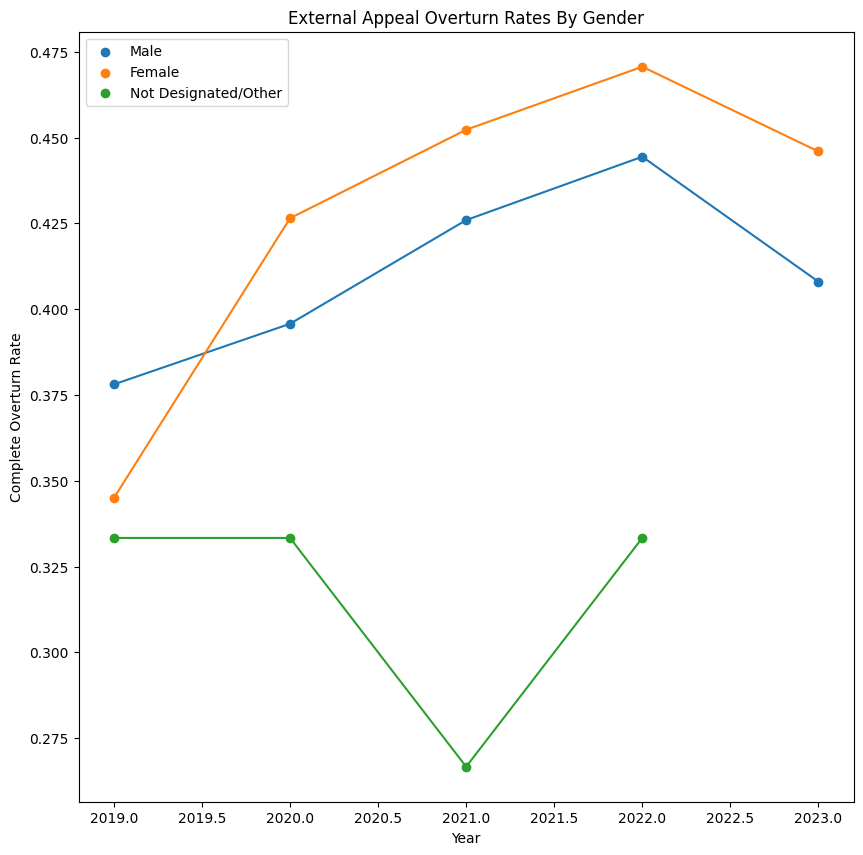

In [103]:
# Plot gender decision rates over time
fig, ax = plt.subplots(figsize=(10,10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeal Overturn Rates By Gender")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
for age in gender_decision_data:
    age_timeseries = []
    for year in x:
        if gender_decision_data[age].get(year, None):
            age_timeseries.append(gender_decision_data[age][year]["complete_overturn_rate"])
        else:
            age_timeseries.append(None)
    ax.scatter(x, age_timeseries, label=age)
    ax.plot(x, age_timeseries)
ax.legend()
plt.show()


In [6]:
print(df["Summary 1"][131])

Diagnosis: Primary hyperparathyroidism; multinodular goiter
Treatment: Inpatient hospital admission
Summary:  The inpatient hospital admission was not medically necessary.
Acute inpatient hospitalization was not medically necessary for this patient for the dates of service under review.  The medical records support that this patient could have been reasonably and safely monitored with an observational status (rather than acute inpatient admission).
This patient presented with the diagnosis of hyperparathyroidism and a multinodular goiter.  She underwent total thyroidectomy, parathyroidectomy (right inferior, right superior, portion of left inferior), right central neck dissection, cervical thymectomy with intraoperative RLN and iPTH monitoring.  
While there is risk for post-operative hypocalcemia following parathyroidectomy, this risk is minimized by the identification of each parathyroid gland that was performed in this case.  Also, the nadir for post-surgical calcium is not typicall

In [13]:
# Idea: train a model to determine whether a scenario will be deemed medically necessary by an external review board.

## PUF

In [11]:
puf_path = "/home/mike/data/practice_data/Transparency_in_Coverage_PUF.xlsx"
puf = pd.read_excel(puf_path, sheet_name=1)
# 2021 plan year data
# Get rid of junk rows
puf.columns = puf.iloc[1]
puf = puf.iloc[2:]

In [28]:
len(puf)

6764

In [29]:
len(puf["Issuer_Claims_Received"].unique())

164

In [31]:
len(puf["Issuer_ID"].unique())

230

In [9]:
def isolate_well_reported():
    pass

def isolate_medical(df):
    df = df[df['SADP_Only?'] == "No"]
    return df

def isolate_QHP(df):
    df = df[df["QHP/SADP"] == "QHP"]
    return df

1,State,Issuer_Name,Issuer_ID,Is_Issuer_New_to_Exchange? (Yes_or_No),SADP_Only?,Plan_ID,QHP/SADP,Plan_Type,Metal_Level,URL_Claims_Payment_Policies,Issuer_Claims_Received,Issuer_Claims_Denials,Issuer_Internal_Appeals_Filed,Issuer_Number_Internal_Appeals_Overturned,Issuer_Percent_Internal_Appeals_Overturned,Issuer_External_Appeals_Filed,Issuer_Number_External_Appeals_Overturned,Issuer_Percent_External_Appeals_Overturned,Plan_Number_Claims_Received,Plan_Number_Claims_Denied,Plan_Number_Claims_Denied_Referral_Required,Plan_Number_Claims_Denied_Out_of_Network,Plan_Number_Claims_Denied_Services_Excluded,Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health,Plan_Number_Claims_Denied_Not_Medically_Necessary_Behavioral_Health_Only,Plan_Number_Claims_Denied_Other,Rate_Review,Financial_Information,Average Monthly Enrollment,Average Monthly Disenrollment
2,AK,Premera Blue Cross Blue Shield of Alaska,38344,No,No,38344AK1060001,QHP,PPO,Gold,https://www.premera.com/visitor/transparency-c...,603348,143208,2156,1079,50.05,**,**,**,259304,59633,11433,143,6071,818,**,89942,https://ratereview.healthcare.gov/,https://www.naic.org/cis_refined_results.htm?T...,6428,728
3,AK,Premera Blue Cross Blue Shield of Alaska,38344,No,No,38344AK1060002,QHP,PPO,Silver,https://www.premera.com/visitor/transparency-c...,603348,143208,2156,1079,50.05,**,**,**,100437,26239,4720,95,2663,182,**,36773,https://ratereview.healthcare.gov/,https://www.naic.org/cis_refined_results.htm?T...,2109,232
4,AK,Premera Blue Cross Blue Shield of Alaska,38344,No,No,38344AK1060004,QHP,PPO,Bronze Expanded,https://www.premera.com/visitor/transparency-c...,603348,143208,2156,1079,50.05,**,**,**,115878,26136,4786,20,2765,127,**,43716,https://ratereview.healthcare.gov/,https://www.naic.org/cis_refined_results.htm?T...,3605,479
5,AK,Premera Blue Cross Blue Shield of Alaska,38344,No,No,38344AK1070002,QHP,PPO,Bronze Expanded,https://www.premera.com/visitor/transparency-c...,603348,143208,2156,1079,50.05,**,**,**,75481,20063,1322,37,1586,87,**,31298,https://ratereview.healthcare.gov/,https://www.naic.org/cis_refined_results.htm?T...,3139,391
6,AK,Premera Blue Cross Blue Shield of Alaska,38344,No,No,38344AK1080001,QHP,PPO,Gold,https://www.premera.com/visitor/transparency-c...,603348,143208,2156,1079,50.05,**,**,**,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://ratereview.healthcare.gov/,https://www.naic.org/cis_refined_results.htm?T...,*,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6761,WY,Montana Health Cooperative,38576,No,No,38576WY0020003,QHP,PPO,Bronze Expanded,https://mountainhealth.coop/members/#your-cove...,64754,5303,173,50,28.9,0,0,**,3083,279,0,0,32,15,13,219,https://ratereview.healthcare.gov/,https://www.naic.org/cis_refined_results.htm?T...,162,23
6762,WY,Montana Health Cooperative,38576,No,No,38576WY0020004,QHP,PPO,Bronze Expanded,https://mountainhealth.coop/members/#your-cove...,64754,5303,173,50,28.9,0,0,**,6972,621,0,0,47,**,52,515,https://ratereview.healthcare.gov/,https://www.naic.org/cis_refined_results.htm?T...,289,30
6763,WY,Montana Health Cooperative,38576,No,No,38576WY0020008,QHP,PPO,Gold,https://mountainhealth.coop/members/#your-cove...,64754,5303,173,50,28.9,0,0,**,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://ratereview.healthcare.gov/,https://www.naic.org/cis_refined_results.htm?T...,*,*
6764,WY,Montana Health Cooperative,38576,No,No,38576WY0020009,QHP,PPO,Silver,https://mountainhealth.coop/members/#your-cove...,64754,5303,173,50,28.9,0,0,**,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://ratereview.healthcare.gov/,https://www.naic.org/cis_refined_results.htm?T...,*,*


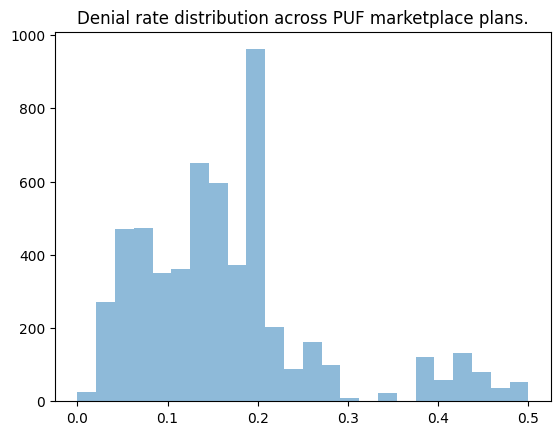

In [54]:
# Calculate issuer denial rate:
import numpy as np
import matplotlib.pyplot as plt
def denial_rate(row):
    recvd = row["Issuer_Claims_Received"]
    denied = row["Issuer_Claims_Denials"]
    if type(recvd) is str and type(denied) is str:
        return int(denied) / int(recvd)
    else:
        return -1

# Calculate denial rates where possible
puf["denial_rate"] = puf.apply(denial_rate, axis=1)
denial_rates = puf[puf["denial_rate"] != -1]


# Plot hist of denial rate:
fig, ax = plt.subplots()
ax.set_title("Denial rate distribution across PUF marketplace plans.")
ax.hist(denial_rates["denial_rate"], alpha=.5, bins=np.linspace(0, .5, 25))
plt.show()

In [22]:
puf["State"].value_counts()

TX    1090
FL     687
WI     537
NC     429
TN     416
IL     392
OH     341
GA     338
AZ     289
MI     231
MO     205
OK     195
NE     194
VA     145
KS     128
LA     127
UT      99
MT      97
SC      93
IN      88
IA      84
OR      77
MS      72
SD      64
ND      62
AL      59
NH      55
AR      51
DE      30
WV      26
WY      25
HI      22
AK      16
Name: State, dtype: int64

## PUF Files

In [35]:
def split_puf_sheet(puf_path, sheet_name):
    """Split off the title, legend and actual data from CMS puf.
    """
    df = pd.read_excel(puf_path, engine="openpyxl", sheet_name=sheet_name)
    title = df.keys()[0]
    legend = df.iloc[0][0]

    # reassign header
    data = df.iloc[1:]
    headers = data.iloc[0]
    data = data[1:]
    data.columns = headers

    return title, legend, data

In [36]:
puf_path_2023 = '/home/mike/data/practice_data/Transparency_in_Coverage_PUF.xlsx'
sheet_name = "Transparency 2023 - Ind QHP"
title, legend, df = split_puf_sheet(puf_path_2023, sheet_name)

# This is delivered as xlsx, with a title row and legend row, which making parsing this as a dataframe
# unnecessarily difficult. Why CMS, just why?

print(f"{title}\n\n{legend}")

Individual Marketplace Medical Qualified Health Plans (QHPs)

Legend 
*                              Data not available for this issuer/plan
**                            Suppressed data due to small cell sizes                  
***                          Data not required due to plan type
N/A                         Data not applicable because issuer or plan offering is new to the Exchange
Missing URL            Financial Link unavailable on NAIC website


In [45]:
# General utilities
def isolate_complete_issuers(df):
    pass

def isolate_complete_plans(df):
    pass

def isolate_medical(df):
    df = df[df['SADP_Only?'] == "No"]
    return df

def isolate_QHP(df):
    df = df[df["QHP/SADP"] == "QHP"]
    return df

def clean(data, year):
    "Clean and return numerical data"

    # Add plan year as convenience:
    data["denial_stats_year"] = year


    if year == 2023:
        integral_columns = ['Issuer_Claims_Received', 'Issuer_Claims_Denials',
                            'Issuer_Internal_Appeals_Filed',
                            'Issuer_Number_Internal_Appeals_Overturned',
                            'Issuer_Percent_Internal_Appeals_Overturned',
                            'Issuer_External_Appeals_Filed',
                            'Issuer_Number_External_Appeals_Overturned',
                            'Issuer_Percent_External_Appeals_Overturned',
                            'Plan_Number_Claims_Received', 'Plan_Number_Claims_Denied',
                            'Plan_Number_Claims_Denied_Referral_Required',
                            'Plan_Number_Claims_Denied_Out_of_Network',
                            'Plan_Number_Claims_Denied_Services_Excluded',
                            'Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health',
                            'Plan_Number_Claims_Denied_Not_Medically_Necessary_Behavioral_Health_Only',
                            'Plan_Number_Claims_Denied_Other', 'Average Monthly Enrollment',
                            'Average Monthly Disenrollment']
        other_columns = ['State', 'Issuer_Name', 'Issuer_ID', 'Is_Issuer_New_to_Exchange? (Yes_or_No)',
                         'SADP_Only?', 'Plan_ID', 'QHP/SADP', 'Plan_Type', 'Metal_Level',]
        not_null_columns = []

    if year == 2021:
        # 2021 numerical columns
        integral_columns = ['Issuer_ID', 'Issuer_Name', 'Issuer_Claims_Received', 'Issuer_Claims_Denials', 
                    'Issuer_Internal_Appeals_Filed', 'Issuer_Number_Internal_Appeals_Overturned',
                    'Issuer_Percent_Internal_Appeals_Overturned', 'Issuer_External_Appeals_Filed',
                    'Issuer_Number_External_Appeals_Overturned', 'Issuer_Percent_External_Appeals_Overturned',
                    'Plan_Number_Claims_Received', 'Plan_Number_Claims_Denied', 
                    'Plan_Number_Claims_Denied_Referral_Required',
                    'Plan_Number_Claims_Denied_Out_of_Network',
                    'Plan_Number_Claims_Denied_Services_Excluded',
                    'Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health',
                    #'Plan_Number_Claims_Denied_Not_Medically_Necessary_Incl_Behavioral_Health',
                    'Plan_Number_Claims_Denied_Other', 'Enrollment_Data', 'Disenrollment_Data']
        not_null_columns = ["Issuer_Claims_Received", "Issuer_Claims_Denials"]
        

    if year == 2020:
        # 2020 numerical columns
        integral_columns = ['Issuer_ID', 'Issuer_Name', 'Issuer_Claims_Received', 'Issuer_Claims_Denials', 
                            'Issuer_Internal_Appeals_Filed', 'Issuer_Number_Internal_Appeals_Overturned',
                            'Issuer_Percent_Internal_Appeals_Overturned', 'Issuer_External_Appeals_Filed',
                            'Issuer_Number_External_Appeals_Overturned', 'Issuer_Percent_External_Appeals_Overturned',
                            'Plan_Number_Claims_Received', 'Plan_Number_Claims_Denied', 
                            'Plan_Number_Claims_Denied_Referral_Required',
                            'Plan_Number_Claims_Denied_Out_of_Network',
                            'Plan_Number_Claims_Denied_Services_Excluded',
                            'Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health',
                            #'Plan_Number_Claims_Denied_Not_Medically_Necessary_Incl_Behavioral_Health',
                            'Plan_Number_Claims_Denied_Other', 'Enrollment_Data', 'Disenrollment_Data']
        not_null_columns = ["Issuer_Claims_Received", "Issuer_Claims_Denials"]

    if (year == 2019) or (year ==2018):
        # 2019 numerical columns
        integral_columns = ['Issuer_ID', 'Issuer_Name', 'Claims_Received', 'Claims_Denials', 
                             'Internal_Appeals Filed', 'Number_Internal_Appeals_Overturned',
                            'Percent_Internal_Appeals_Overturned', 'External Appeals Filed',
                            'Number_External_Appeals_Overturned', 'Percent_External_Appeals_Overturned',
                            'Enrollment_Data', 'Disenrollment_Data']
        not_null_columns = ["Claims_Received", "Claims_Denials"]

    # Get non NA values for now
    if year in [2018, 2019]:
        nm_data = data[integral_columns + ["State"]].dropna()
    if year in [2020, 2021]:
        nm_data = data[integral_columns + ["State", "Plan_ID"]].dropna()

    if year in [2018, 2019]:
        nm_data = nm_data[~nm_data["Claims_Received"].isin(["*", "**"])]
        nm_data = nm_data[~nm_data["Claims_Denials"].isin(["*", "**"])]
    if year in [2020, 2021, 2023]:
        nm_data = nm_data[~nm_data["Issuer_Claims_Received"].isin(["*", "**"])]
        nm_data = nm_data[~nm_data["Issuer_Claims_Denials"].isin(["*", "**"])]
    # Remove rows where claims are less than denials, some bug in reporting:
    if (year == 2019) or (year ==2018):
        nm_data = nm_data[nm_data["Claims_Received"] > nm_data["Claims_Denials"]]
    # Remove erroneous cases of claims received > claims_denied
    if (year == 2020) or (year ==2021) or (year == 2023):
        nm_data = nm_data[nm_data["Issuer_Claims_Received"] > nm_data["Issuer_Claims_Denials"]]
        

    for column in integral_columns:
        nm_data[f"{column}"] = pd.to_numeric(nm_data[f"{column}"], errors='coerce')
    for column in not_null_columns:
        nm_data = nm_data[nm_data[f"{column}"].notna()]
        nm_data[f"{column}"] = nm_data[f"{column}"].astype(int)
        
    if (year == 2019) or (year ==2018):
        nm_data = nm_data[nm_data["Claims_Received"] > 1000]

    if (year == 2020) or (year ==2021):
        nm_data = nm_data[nm_data["Issuer_Claims_Received"] > 1000]
    return nm_data


def get_issuer_level_dfs(dfs):
    issuer_level_dfs = []
    for df in dfs:
        issuer_level_df = df.groupby("Issuer_ID").first()
        issuer_level_dfs.append(issuer_level_df)
    return issuer_level_dfs

def get_plan_level_dfs(dfs):
    plan_level_dfs = []
    for df in dfs:
        plan_level_df = df.groupby("Plan_ID").first()
        plan_level_dfs.append(plan_level_df)
    return plan_level_dfs

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 38)

In [42]:
df["Issuer_Claims_Received"].isna().sum()

1169

In [ ]:
# Motivating Questions Across Data Sources


# Plot denial rates by state, by year


# Plot denial rates by insurer, by year (how it is progressing?)


# Plot denial type by insurer, by state? What dominates for each insurer, where to focus?

# KFF looks only at insurers from marketplace with "complete" data.

# How often do consumers get denied?

# How often do they appeal?

# How often do they win appeals (internal)?

# How often do they external appeal?

# How often do they win appeals (external)?

# How often do they win, period?



In [ ]:
## TODO From this:

1. Create a Deck (Persius MO).
2. Write a detailed report (like KHN) +  arxiv paper.
3. Write a blog post.
4. Publish CT data, other data summaries?